In [ ]:
import shap
import seaborn as sns
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

train_df = pd.read_csv("data/processed/train_engineered.csv")
val_df = pd.read_csv("data/processed/validation_engineered.csv")

# Separate features & target
X_train, y_train = train_df.drop(columns=["Attrition"]), train_df["Attrition"]
X_val, y_val = val_df.drop(columns=["Attrition"]), val_df["Attrition"]

print(X_train.head())
print(X_train.isnull().sum())

    Age  Gender  Years at Company  Monthly Income  Number of Promotions  \
0  56.0       1              38.0          4082.0                   0.0   
1  27.0       0               2.0          4540.0                   0.0   
2  51.0       0              36.0          9949.0                   3.0   
3  44.0       1              30.0          5058.0                   0.0   
4  33.0       1              19.0          4523.0                   1.0   

   Overtime  Distance from Home  Number of Dependents  Remote Work  \
0         0                64.0                   4.0            1   
1         0                95.0                   1.0            0   
2         0                43.0                   3.0            0   
3         1                76.0                   5.0            0   
4         1                18.0                   2.0            0   

   Leadership Opportunities  ...  Employee Recognition_High  \
0                         0  ...                        0.0   
1 

In [2]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_val, xgb_preds))
print(classification_report(y_val, xgb_preds, target_names=["Stayed", "Left"]))

/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:49:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
Accuracy: 0.7580244642692909
              precision    recall  f1-score   support

      Stayed       0.77      0.77      0.77      5681
        Left       0.75      0.75      0.75      5192

    accuracy                           0.76     10873
   macro avg       0.76      0.76      0.76     10873
weighted avg       0.76      0.76      0.76     10873



              precision    recall  f1-score       support
Stayed         0.769054  0.767294  0.768173   5681.000000
Left           0.746013  0.747881  0.746946   5192.000000
accuracy       0.758024  0.758024  0.758024      0.758024
macro avg      0.757534  0.757588  0.757560  10873.000000
weighted avg   0.758052  0.758024  0.758037  10873.000000
Saved 2631 misclassified samples to 'misclassified_samples.csv'


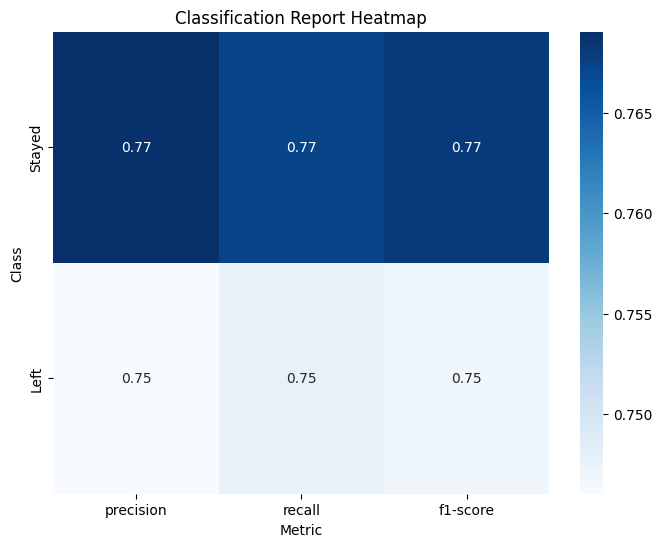

In [7]:
# Get report as a dictionary
report = classification_report(y_val, xgb_preds, target_names=["Stayed", "Left"], output_dict=True)

# Convert to DataFrame for plotting
report_df = pd.DataFrame(report).transpose()

print(report_df)

# Add predictions to a copy of X_val
df_val = X_val.copy()
df_val["True_Label"] = y_val
df_val["Predicted_Label"] = xgb_preds

# Create a misclassified flag
df_val["Misclassified"] = df_val["True_Label"] != df_val["Predicted_Label"]

# Filter misclassified rows
misclassified_df = df_val[df_val["Misclassified"] == True]

# (Optional) Filter misclassified "Left" predictions only
# misclassified_df = misclassified_df[misclassified_df["True_Label"] == 1]

# Save to CSV for SHAP
misclassified_df.to_csv("misclassified_samples.csv", index=False)
print(f"Saved {len(misclassified_df)} misclassified samples to 'misclassified_samples.csv'")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:2, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.ylabel("Class")
plt.xlabel("Metric")
plt.show()

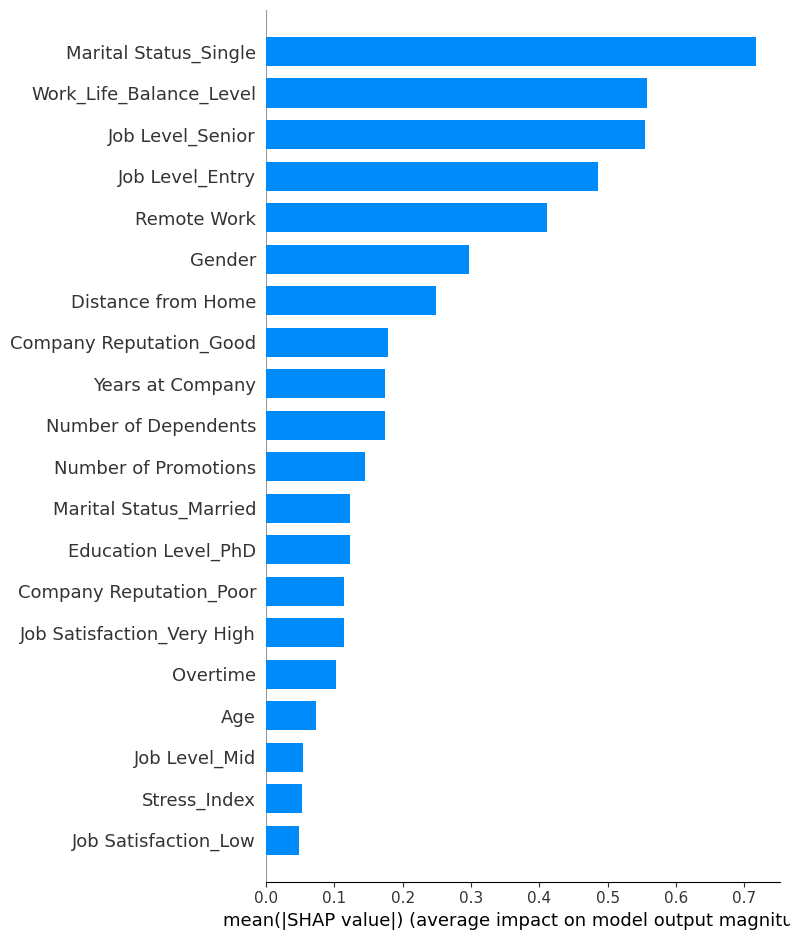

In [9]:
# Drop non-feature columns before SHAP
X_misclassified = misclassified_df.drop(columns=["True_Label", "Predicted_Label", "Misclassified"])

# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_misclassified)

# Calculate SHAP values
shap_values = explainer(X_misclassified)

# Show global feature impact on misclassifications
shap.summary_plot(shap_values, X_misclassified, plot_type="bar")

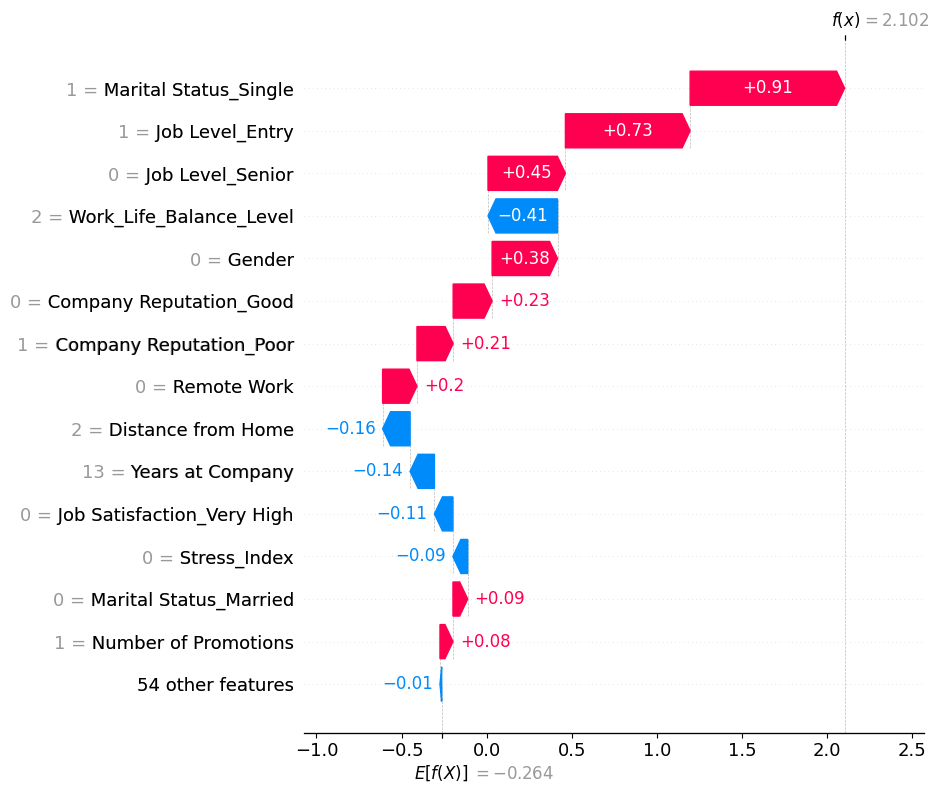

In [10]:
# Pick one misclassified row to explain
i = 0  # or any other row index
shap.plots.waterfall(shap_values[i], max_display=15)


In [11]:
# Assume df_val is your validation DataFrame with true and predicted labels
df_val["Correct"] = df_val["True_Label"] == df_val["Predicted_Label"]

# Accuracy by marital status
segment_accuracy = df_val.groupby("Marital Status_Single")["Correct"].mean()
print(segment_accuracy)


Marital Status_Single
0.0    0.746373
1.0    0.779339
Name: Correct, dtype: float64


In [12]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=100)
cat_model.fit(X_train, y_train)

y_pred = cat_model.predict(X_val)

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=["Stayed", "Left"]))


Learning rate set to 0.051623
0:	learn: 0.6718869	total: 57.4ms	remaining: 57.4s
100:	learn: 0.4722434	total: 625ms	remaining: 5.56s
200:	learn: 0.4590648	total: 1.13s	remaining: 4.48s
300:	learn: 0.4483168	total: 1.61s	remaining: 3.73s
400:	learn: 0.4385731	total: 2.08s	remaining: 3.11s
500:	learn: 0.4299462	total: 2.56s	remaining: 2.55s
600:	learn: 0.4222926	total: 3.03s	remaining: 2.01s
700:	learn: 0.4149441	total: 3.49s	remaining: 1.49s
800:	learn: 0.4078199	total: 3.98s	remaining: 988ms
900:	learn: 0.4010128	total: 4.44s	remaining: 488ms
999:	learn: 0.3949383	total: 4.9s	remaining: 0us
XGBoost Results:
Accuracy: 0.7575646095833717
              precision    recall  f1-score   support

      Stayed       0.77      0.77      0.77      5681
        Left       0.75      0.74      0.75      5192

    accuracy                           0.76     10873
   macro avg       0.76      0.76      0.76     10873
weighted avg       0.76      0.76      0.76     10873



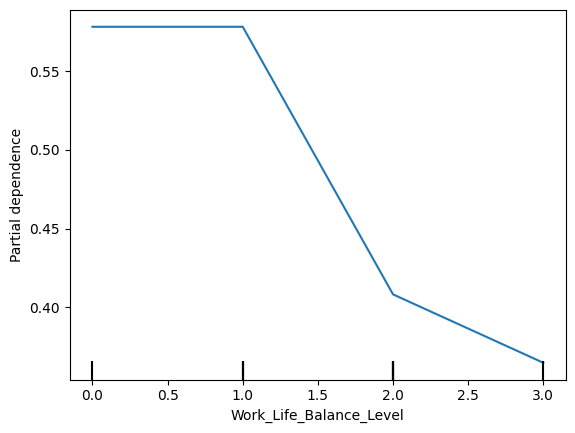

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Use a tree-based model like XGBoost or RandomForest
PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_val,
    features=["Work_Life_Balance_Level"], 
    kind="average"
)
